In [2]:
import gc
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import csr_matrix, hstack
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error
import lightgbm as lgb
from  datetime import datetime
from sklearn.base import TransformerMixin
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from collections import OrderedDict
pd.set_option('display.max_columns', 500)
%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 10]

### Exploratory Data Analysis

In [3]:
training_data = pd.read_csv('train.csv')
sample_submission = pd.read_csv("Sample_sub.csv")

In [4]:
sample_submission.head()

,ID,Capture_Number
0,CaptureSite_0_201901,7
1,CaptureSite_0_201902,1
2,CaptureSite_0_201903,5
3,CaptureSite_0_201904,2
4,CaptureSite_0_201905,3


In [5]:
training_data.head()

,Rescue_ID,Date_TimeCaught,Researcher,CaptureSite,ForagingGround,CaptureMethod,Fisher,LandingSite,Species,Tag_1,Tag_2,Lost_Tags,T_Number,CCL_cm,CCW_cm,Weight_Kg,Sex,TurtleCharacteristics,Status,ReleaseSite,Date_TimeRelease
0,2000_RE_0060,2000-12-22,Researcher_25,CaptureSite_0,Ocean,Net,Fisher_1072,LandingSite_CaptureSiteCategory_2,Species_6,CC00147,None,NaN,NaN,64.70,62.60,NaN,Unknown,algae at rear of shell,Released,ReleaseSite_50,22/12/00
1,2001_RE_0187,2001-10-28,Researcher_6,CaptureSite_0,Ocean,Net,Fisher_520,LandingSite_CaptureSiteCategory_2,Species_6,W442,None,NaN,NaN,35.85,31.35,NaN,Unknown,multiple b's on front flippers& a lot of alga...,Released,ReleaseSite_62,28/10/01
2,2001_RE_0197,2001-11-01,Researcher_6,CaptureSite_0,Ocean,Net,Fisher_1669,LandingSite_CaptureSiteCategory_2,Species_5,KE0376,None,NaN,NaN,51.80,49.20,NaN,Unknown,clean,Released,ReleaseSite_50,01/11/01
3,2002_RE_0031,2002-03-11,Researcher_32,CaptureSite_0,Ocean,Net,Fisher_1798,LandingSite_CaptureSiteCategory_2,Species_6,CC00302,None,NaN,NaN,60.50,59.00,NaN,Unknown,1 b 3 CS+ calcerous algae at rear end of shell...,Released,ReleaseSite_50,11/03/02
4,2002_RE_0118,2002-08-08,Researcher_25,CaptureSite_0,Ocean,Beached,Fisher_1918,LandingSite_CaptureSiteCategory_2,Species_5,NotTagged_0113,None,NaN,NaN,34.70,33.00,NaN,Unknown,very lively+ right eye is hanging out + swolle...,Released,ReleaseSite_62,08/08/02


In [6]:
training_data['LandingSite'].unique() #Unique  landing sites 

array(['LandingSite_CaptureSiteCategory_2',
       'LandingSite_CaptureSiteCategory_0',
       'LandingSite_CaptureSiteCategory_4',
       'LandingSite_CaptureSiteCategory_1',
       'LandingSite_CaptureSiteCategory_3'], dtype=object)

In [7]:
categ = pd.read_csv('CaptureSite_category.csv')
categ

,CaptureSite,CaptureSiteCategory,Type
0,CaptureSite_0,CaptureSiteCategory_2,Type_1
1,CaptureSite_1,CaptureSiteCategory_2,Type_1
2,CaptureSite_10,CaptureSiteCategory_2,Type_1
3,CaptureSite_11,CaptureSiteCategory_0,Type_0
4,CaptureSite_12,CaptureSiteCategory_2,Type_1
5,CaptureSite_13,CaptureSiteCategory_2,Type_1
6,CaptureSite_14,CaptureSiteCategory_4,Type_0
7,CaptureSite_15,CaptureSiteCategory_0,Type_0
8,CaptureSite_16,CaptureSiteCategory_4,Type_0
9,CaptureSite_17,CaptureSiteCategory_4,Type_0


In [9]:
print(categ.shape,training_data.shape)

(29, 3) (18062, 21)


## Pre-Preprocessing  


In [10]:
df = pd.merge(categ, training_data, on='CaptureSite', right_index=True) #merge  categories and  training data
 

,CaptureSite,CaptureSiteCategory,Type,Rescue_ID,Date_TimeCaught,Researcher,ForagingGround,CaptureMethod,Fisher,LandingSite,Species,Tag_1,Tag_2,Lost_Tags,T_Number,CCL_cm,CCW_cm,Weight_Kg,Sex,TurtleCharacteristics,Status,ReleaseSite,Date_TimeRelease
0,CaptureSite_0,CaptureSiteCategory_2,Type_1,2000_RE_0060,2000-12-22,Researcher_25,Ocean,Net,Fisher_1072,LandingSite_CaptureSiteCategory_2,Species_6,CC00147,None,NaN,NaN,64.70,62.60,NaN,Unknown,algae at rear of shell,Released,ReleaseSite_50,22/12/00
0,CaptureSite_0,CaptureSiteCategory_2,Type_1,2001_RE_0187,2001-10-28,Researcher_6,Ocean,Net,Fisher_520,LandingSite_CaptureSiteCategory_2,Species_6,W442,None,NaN,NaN,35.85,31.35,NaN,Unknown,multiple b's on front flippers& a lot of alga...,Released,ReleaseSite_62,28/10/01
0,CaptureSite_0,CaptureSiteCategory_2,Type_1,2001_RE_0197,2001-11-01,Researcher_6,Ocean,Net,Fisher_1669,LandingSite_CaptureSiteCategory_2,Species_5,KE0376,None,NaN,NaN,51.80,49.20,NaN,Unknown,clean,Released,ReleaseSite_50,01/11/01
0,CaptureSite_0,CaptureSiteCategory_2,Type_1,2002_RE_0031,2002-03-11,Researcher_32,Ocean,Net,Fisher_1798,LandingSite_CaptureSiteCategory_2,Species_6,CC00302,None,NaN,NaN,60.50,59.00,NaN,Unknown,1 b 3 CS+ calcerous algae at rear end of shell...,Released,ReleaseSite_50,11/03/02
0,CaptureSite_0,CaptureSiteCategory_2,Type_1,2002_RE_0118,2002-08-08,Researcher_25,Ocean,Beached,Fisher_1918,LandingSite_CaptureSiteCategory_2,Species_5,NotTagged_0113,None,NaN,NaN,34.70,33.00,NaN,Unknown,very lively+ right eye is hanging out + swolle...,Released,ReleaseSite_62,08/08/02


In [11]:
df.tail()

,CaptureSite,CaptureSiteCategory,Type,Rescue_ID,Date_TimeCaught,Researcher,ForagingGround,CaptureMethod,Fisher,LandingSite,Species,Tag_1,Tag_2,Lost_Tags,T_Number,CCL_cm,CCW_cm,Weight_Kg,Sex,TurtleCharacteristics,Status,ReleaseSite,Date_TimeRelease
28,CaptureSite_9,CaptureSiteCategory_1,Type_1,2018_RE_1511,2018-12-18,Researcher_30,Ocean,Net,Fisher_569,LandingSite_CaptureSiteCategory_1,Species_5,KES1828,None,NaN,NaN,57.13,50.57,21.09,Unknown,White calcareous algae on carapace,Released,ReleaseSite_68,18/12/18
28,CaptureSite_9,CaptureSiteCategory_1,Type_1,2018_RE_1514,2018-12-18,Researcher_30,Ocean,Net,Fisher_125,LandingSite_CaptureSiteCategory_1,Species_6,KES0563,None,KES0416,NaN,42.07,38.37,9.02,Unknown,Calcareous + green algae on carapace\nBarnacle...,Released,ReleaseSite_68,18/12/18
28,CaptureSite_9,CaptureSiteCategory_1,Type_1,2018_RE_1532,2018-12-24,Researcher_30,Ocean,Net,Fisher_1343,LandingSite_CaptureSiteCategory_1,Species_5,KES1833,None,NaN,NaN,57.20,52.30,NaN,Unknown,Clean turtle,Released,ReleaseSite_68,24/12/18
28,CaptureSite_9,CaptureSiteCategory_1,Type_1,2018_RE_1533,2018-12-24,Researcher_30,Ocean,Net,Fisher_1551,LandingSite_CaptureSiteCategory_1,Species_5,KES1831,None,NaN,NaN,51.90,48.50,NaN,Unknown,Green algae on carapace\ntip of left supra mis...,Released,ReleaseSite_68,24/12/18
28,CaptureSite_9,CaptureSiteCategory_1,Type_1,2018_RE_1550,2018-12-28,Researcher_30,Ocean,Net,Fisher_1551,LandingSite_CaptureSiteCategory_1,Species_6,KES1432,none,NaN,NaN,34.60,31.20,4.29,Unknown,Thick pink patches of calcareous algae on cara...,Released,ReleaseSite_37,28/12/18


In [13]:
df['ForagingGround'].value_counts() ##

Creek    11408
Ocean     6651
creek        3
Name: ForagingGround, dtype: int64

In [14]:
df.loc[df['ForagingGround']=='creek', 'ForagingGround']='Creek' #Change creek to Creek. Hope you see the difference 

In [15]:
df

,CaptureSite,CaptureSiteCategory,Type,Rescue_ID,Date_TimeCaught,Researcher,ForagingGround,CaptureMethod,Fisher,LandingSite,Species,Tag_1,Tag_2,Lost_Tags,T_Number,CCL_cm,CCW_cm,Weight_Kg,Sex,TurtleCharacteristics,Status,ReleaseSite,Date_TimeRelease
0,CaptureSite_0,CaptureSiteCategory_2,Type_1,2000_RE_0060,2000-12-22,Researcher_25,Ocean,Net,Fisher_1072,LandingSite_CaptureSiteCategory_2,Species_6,CC00147,None,NaN,NaN,64.70,62.60,NaN,Unknown,algae at rear of shell,Released,ReleaseSite_50,22/12/00
0,CaptureSite_0,CaptureSiteCategory_2,Type_1,2001_RE_0187,2001-10-28,Researcher_6,Ocean,Net,Fisher_520,LandingSite_CaptureSiteCategory_2,Species_6,W442,None,NaN,NaN,35.85,31.35,NaN,Unknown,multiple b's on front flippers& a lot of alga...,Released,ReleaseSite_62,28/10/01
0,CaptureSite_0,CaptureSiteCategory_2,Type_1,2001_RE_0197,2001-11-01,Researcher_6,Ocean,Net,Fisher_1669,LandingSite_CaptureSiteCategory_2,Species_5,KE0376,None,NaN,NaN,51.80,49.20,NaN,Unknown,clean,Released,ReleaseSite_50,01/11/01
0,CaptureSite_0,CaptureSiteCategory_2,Type_1,2002_RE_0031,2002-03-11,Researcher_32,Ocean,Net,Fisher_1798,LandingSite_CaptureSiteCategory_2,Species_6,CC00302,None,NaN,NaN,60.50,59.00,NaN,Unknown,1 b 3 CS+ calcerous algae at rear end of shell...,Released,ReleaseSite_50,11/03/02
0,CaptureSite_0,CaptureSiteCategory_2,Type_1,2002_RE_0118,2002-08-08,Researcher_25,Ocean,Beached,Fisher_1918,LandingSite_CaptureSiteCategory_2,Species_5,NotTagged_0113,None,NaN,NaN,34.70,33.00,NaN,Unknown,very lively+ right eye is hanging out + swolle...,Released,ReleaseSite_62,08/08/02
0,CaptureSite_0,CaptureSiteCategory_2,Type_1,2002_RE_0119,2002-08-10,Researcher_25,Ocean,Not_Recorded,Fisher_1918,LandingSite_CaptureSiteCategory_2,Species_5,NotTagged_0114,None,NaN,NaN,33.20,30.70,NaN,Unknown,large chip 6 LM,Released,ReleaseSite_8,10/08/02
0,CaptureSite_0,CaptureSiteCategory_2,Type_1,2002_RE_0214,2002-10-21,Researcher_25,Ocean,Net,Fisher_2013,LandingSite_CaptureSiteCategory_2,Species_6,KA460,None,NaN,NaN,37.40,33.50,NaN,Unknown,green and whitish-pink calcerous algae growth ...,Released,ReleaseSite_62,21/10/02
0,CaptureSite_0,CaptureSiteCategory_2,Type_1,2002_RE_0215,2002-10-21,Researcher_25,Ocean,Net,Fisher_1815,LandingSite_CaptureSiteCategory_2,Species_6,KA442,None,NaN,NaN,40.30,37.20,NaN,Unknown,calcerous algae growth-especially rear end and...,Released,ReleaseSite_50,21/10/02
0,CaptureSite_0,CaptureSiteCategory_2,Type_1,2002_RE_0218,2002-10-22,Researcher_30,Ocean,Net,Fisher_1815,LandingSite_CaptureSiteCategory_2,Species_5,KA466,None,NaN,NaN,44.00,43.20,NaN,Unknown,clean shell,Released,ReleaseSite_50,22/10/02
0,CaptureSite_0,CaptureSiteCategory_2,Type_1,2003_RE_0187,2003-06-09,Researcher_32,Ocean,Net,Fisher_1066,LandingSite_CaptureSiteCategory_2,Species_5,KE1184,None,NaN,NaN,48.30,43.30,NaN,Unknown,10 LMS has a small chip& right rear flipper is...,Released,ReleaseSite_62,NaN


In [16]:
df['TurtleCharacteristics'].nunique()

16343

## Date variables  manipulations  


In [17]:
#Breakdown Date_TimeCaught to months, weeks etc 
df['Date_TimeCaught'] = pd.to_datetime(df['Date_TimeCaught'], format='%Y-%m-%d')
df['year_caught'] = df['Date_TimeCaught'].dt.year
df['month_caught'] = df['Date_TimeCaught'].dt.month
df['week_of_year_caught'] = df['Date_TimeCaught'].dt.week
df['day_caught'] = df['Date_TimeCaught'].dt.day
df['day_of_week_caught'] = pd.DatetimeIndex(df['Date_TimeCaught']).dayofweek
df["year_woy"]=df.year_caught*100+df.week_of_year_caught
df['day_of_year']= pd.DatetimeIndex(df['Date_TimeCaught']).dayofyear

In [18]:
df.head()

,CaptureSite,CaptureSiteCategory,Type,Rescue_ID,Date_TimeCaught,Researcher,ForagingGround,CaptureMethod,Fisher,LandingSite,Species,Tag_1,Tag_2,Lost_Tags,T_Number,CCL_cm,CCW_cm,Weight_Kg,Sex,TurtleCharacteristics,Status,ReleaseSite,Date_TimeRelease,year_caught,month_caught,week_of_year_caught,day_caught,day_of_week_caught,year_woy,day_of_year
0,CaptureSite_0,CaptureSiteCategory_2,Type_1,2000_RE_0060,2000-12-22,Researcher_25,Ocean,Net,Fisher_1072,LandingSite_CaptureSiteCategory_2,Species_6,CC00147,None,NaN,NaN,64.70,62.60,NaN,Unknown,algae at rear of shell,Released,ReleaseSite_50,22/12/00,2000,12,51,22,4,200051,357
0,CaptureSite_0,CaptureSiteCategory_2,Type_1,2001_RE_0187,2001-10-28,Researcher_6,Ocean,Net,Fisher_520,LandingSite_CaptureSiteCategory_2,Species_6,W442,None,NaN,NaN,35.85,31.35,NaN,Unknown,multiple b's on front flippers& a lot of alga...,Released,ReleaseSite_62,28/10/01,2001,10,43,28,6,200143,301
0,CaptureSite_0,CaptureSiteCategory_2,Type_1,2001_RE_0197,2001-11-01,Researcher_6,Ocean,Net,Fisher_1669,LandingSite_CaptureSiteCategory_2,Species_5,KE0376,None,NaN,NaN,51.80,49.20,NaN,Unknown,clean,Released,ReleaseSite_50,01/11/01,2001,11,44,1,3,200144,305
0,CaptureSite_0,CaptureSiteCategory_2,Type_1,2002_RE_0031,2002-03-11,Researcher_32,Ocean,Net,Fisher_1798,LandingSite_CaptureSiteCategory_2,Species_6,CC00302,None,NaN,NaN,60.50,59.00,NaN,Unknown,1 b 3 CS+ calcerous algae at rear end of shell...,Released,ReleaseSite_50,11/03/02,2002,3,11,11,0,200211,70
0,CaptureSite_0,CaptureSiteCategory_2,Type_1,2002_RE_0118,2002-08-08,Researcher_25,Ocean,Beached,Fisher_1918,LandingSite_CaptureSiteCategory_2,Species_5,NotTagged_0113,None,NaN,NaN,34.70,33.00,NaN,Unknown,very lively+ right eye is hanging out + swolle...,Released,ReleaseSite_62,08/08/02,2002,8,32,8,3,200232,220


In [19]:
df.reset_index(drop=True, inplace=True)

### Look for null values 

In [127]:
df.isnull().sum().sort_values(ascending=False) ## Get the  NaNs 

Date_TimeRelease         6520
Sex                      4330
Status                   3633
ReleaseSite                75
TurtleCharacteristics      41
day_of_year                 0
Species                     0
CaptureSiteCategory         0
Type                        0
Rescue_ID                   0
Date_TimeCaught             0
Researcher                  0
ForagingGround              0
CaptureMethod               0
Fisher                      0
LandingSite                 0
CCL_cm                      0
Tag_1                       0
Tag_2                       0
year_woy                    0
CCW_cm                      0
Weight_Kg                   0
year_caught                 0
month_caught                0
week_of_year_caught         0
day_caught                  0
day_of_week_caught          0
CaptureSite                 0
dtype: int64

In [273]:
# del df['T_Number']
# del df['Lost_Tags']

In [129]:
# taking the median value becuase it outlier-resistant. Try with mean once  this is done  
df['Weight_Kg'].fillna((df['Weight_Kg'].median()), inplace=True)

In [130]:
df.groupby(by = df['CaptureSite']).median()

,CCL_cm,CCW_cm,Weight_Kg,year_caught,month_caught,week_of_year_caught,day_caught,day_of_week_caught,year_woy,day_of_year
CaptureSite,,,,,,,,,,
CaptureSite_0,39.900,38.200,7.500,2014.0,8.0,35.0,16.0,2.0,201430.0,240.0
CaptureSite_1,39.000,36.500,7.130,2013.0,7.0,30.0,17.0,3.0,201326.0,206.0
CaptureSite_10,38.000,35.700,7.345,2016.0,6.0,24.0,15.0,3.0,201650.5,167.5
CaptureSite_11,41.600,40.135,7.500,2009.0,7.0,30.0,17.0,3.0,200914.0,204.0
CaptureSite_12,39.700,37.950,7.500,2010.0,7.0,31.0,16.0,3.0,201048.0,212.0
CaptureSite_13,39.400,37.600,7.500,2014.0,8.0,35.0,15.0,3.0,201444.0,240.0
CaptureSite_14,41.400,39.200,7.500,2013.0,6.0,26.0,18.0,4.0,201313.0,181.0
CaptureSite_15,36.500,34.000,5.785,2015.0,7.0,28.0,16.0,3.0,201503.0,197.0
CaptureSite_16,42.600,40.700,7.500,2011.0,8.0,31.0,16.0,3.0,201117.0,215.0


In [131]:
# a better approach than filling null values with the whole dataset's median would be to fill 
df['CCL_cm'] = df['CCL_cm'].fillna(df.groupby(['CaptureSite'])['CCL_cm'].transform('median'))
df['CCW_cm'] = df['CCW_cm'].fillna(df.groupby(['CaptureSite'])['CCW_cm'].transform('median'))

In [146]:
# For null Date_TimeRelease, insert Date_TimeCaught values if variance is  not so high \
df[['Date_TimeRelease', 'Date_TimeCaught']]

,Date_TimeRelease,Date_TimeCaught
0,22/12/00,2000-12-22
1,28/10/01,2001-10-28
2,01/11/01,2001-11-01
3,11/03/02,2002-03-11
4,08/08/02,2002-08-08
5,10/08/02,2002-08-10
6,21/10/02,2002-10-21
7,21/10/02,2002-10-21
8,22/10/02,2002-10-22
9,NaN,2003-06-09


In [175]:
df['Date_TimeRelease'] = pd.to_datetime(df['Date_TimeRelease'], errors='coerce') #convert Date_TimeRelease to date format 


In [183]:
df.Date_TimeRelease.fillna(df.Date_TimeCaught, inplace=True) #fill NaNs for Date_TimeRelease with Date_TimeCaught

In [119]:
df['Date_TimeRelease'].replace({'NaT': df["Date_TimeCaught"]}, inplace=True)

In [185]:
df.isnull().sum().sort_values(ascending=False)

day_of_year              0
year_woy                 0
CaptureSiteCategory      0
Type                     0
Rescue_ID                0
Date_TimeCaught          0
Researcher               0
ForagingGround           0
CaptureMethod            0
Fisher                   0
LandingSite              0
Species                  0
Tag_1                    0
Tag_2                    0
CCL_cm                   0
CCW_cm                   0
Weight_Kg                0
Sex                      0
TurtleCharacteristics    0
Status                   0
ReleaseSite              0
Date_TimeRelease         0
year_caught              0
month_caught             0
week_of_year_caught      0
day_caught               0
day_of_week_caught       0
CaptureSite              0
dtype: int64

In [173]:
#df1 = df.copy()
df = df2

In [187]:
# df2 = df.copy() #copy the dataframes for the future just in case
# df3 = df.copy() #copy the dataframes for the future just in case

In [186]:
df.head()

,CaptureSite,CaptureSiteCategory,Type,Rescue_ID,Date_TimeCaught,Researcher,ForagingGround,CaptureMethod,Fisher,LandingSite,Species,Tag_1,Tag_2,CCL_cm,CCW_cm,Weight_Kg,Sex,TurtleCharacteristics,Status,ReleaseSite,Date_TimeRelease,year_caught,month_caught,week_of_year_caught,day_caught,day_of_week_caught,year_woy,day_of_year
0,CaptureSite_0,CaptureSiteCategory_2,Type_1,2000_RE_0060,2000-12-22,Researcher_25,Ocean,Net,Fisher_1072,LandingSite_CaptureSiteCategory_2,Species_6,CC00147,None,64.70,62.60,7.5,Unknown,algae at rear of shell,Released,ReleaseSite_50,2000-12-22,2000,12,51,22,4,200051,357
1,CaptureSite_0,CaptureSiteCategory_2,Type_1,2001_RE_0187,2001-10-28,Researcher_6,Ocean,Net,Fisher_520,LandingSite_CaptureSiteCategory_2,Species_6,W442,None,35.85,31.35,7.5,Unknown,multiple b's on front flippers& a lot of alga...,Released,ReleaseSite_62,2001-10-28,2001,10,43,28,6,200143,301
2,CaptureSite_0,CaptureSiteCategory_2,Type_1,2001_RE_0197,2001-11-01,Researcher_6,Ocean,Net,Fisher_1669,LandingSite_CaptureSiteCategory_2,Species_5,KE0376,None,51.80,49.20,7.5,Unknown,clean,Released,ReleaseSite_50,2001-01-11,2001,11,44,1,3,200144,305
3,CaptureSite_0,CaptureSiteCategory_2,Type_1,2002_RE_0031,2002-03-11,Researcher_32,Ocean,Net,Fisher_1798,LandingSite_CaptureSiteCategory_2,Species_6,CC00302,None,60.50,59.00,7.5,Unknown,1 b 3 CS+ calcerous algae at rear end of shell...,Released,ReleaseSite_50,2002-11-03,2002,3,11,11,0,200211,70
4,CaptureSite_0,CaptureSiteCategory_2,Type_1,2002_RE_0118,2002-08-08,Researcher_25,Ocean,Beached,Fisher_1918,LandingSite_CaptureSiteCategory_2,Species_5,NotTagged_0113,None,34.70,33.00,7.5,Unknown,very lively+ right eye is hanging out + swolle...,Released,ReleaseSite_62,2002-08-08,2002,8,32,8,3,200232,220


In [93]:
#df1['Date_TimeRelease'] = pd.to_datetime(df1['Date_TimeRelease'])

#df1['Date_TimeRelease'].str.contains('Release', na=False)
#df1['Date_TimeRelease'] = df1.Date_TimeRelease.str.replace(r'(^.*notches .*$)', '')
#df1['Date_TimeRelease'] = np.where((df1.Date_TimeRelease == ''),np.NaN,df1.Date_TimeRelease) #Worked 

                                                            

In [98]:
# df["Date_TimeRelease"].value_counts()

In [188]:
df['Sex'].value_counts()

Unknown    17910
Female       113
Male          39
Name: Sex, dtype: int64

In [135]:
df['Sex'].fillna('Unknown', inplace=True)

In [136]:
df.loc[df['Sex']=='Not_Recorded', 'Sex']='Unknown'

In [137]:
df.head()

,CaptureSite,CaptureSiteCategory,Type,Rescue_ID,Date_TimeCaught,Researcher,ForagingGround,CaptureMethod,Fisher,LandingSite,Species,Tag_1,Tag_2,CCL_cm,CCW_cm,Weight_Kg,Sex,TurtleCharacteristics,Status,ReleaseSite,Date_TimeRelease,year_caught,month_caught,week_of_year_caught,day_caught,day_of_week_caught,year_woy,day_of_year
0,CaptureSite_0,CaptureSiteCategory_2,Type_1,2000_RE_0060,2000-12-22,Researcher_25,Ocean,Net,Fisher_1072,LandingSite_CaptureSiteCategory_2,Species_6,CC00147,None,64.70,62.60,7.5,Unknown,algae at rear of shell,Released,ReleaseSite_50,22/12/00,2000,12,51,22,4,200051,357
1,CaptureSite_0,CaptureSiteCategory_2,Type_1,2001_RE_0187,2001-10-28,Researcher_6,Ocean,Net,Fisher_520,LandingSite_CaptureSiteCategory_2,Species_6,W442,None,35.85,31.35,7.5,Unknown,multiple b's on front flippers& a lot of alga...,Released,ReleaseSite_62,28/10/01,2001,10,43,28,6,200143,301
2,CaptureSite_0,CaptureSiteCategory_2,Type_1,2001_RE_0197,2001-11-01,Researcher_6,Ocean,Net,Fisher_1669,LandingSite_CaptureSiteCategory_2,Species_5,KE0376,None,51.80,49.20,7.5,Unknown,clean,Released,ReleaseSite_50,01/11/01,2001,11,44,1,3,200144,305
3,CaptureSite_0,CaptureSiteCategory_2,Type_1,2002_RE_0031,2002-03-11,Researcher_32,Ocean,Net,Fisher_1798,LandingSite_CaptureSiteCategory_2,Species_6,CC00302,None,60.50,59.00,7.5,Unknown,1 b 3 CS+ calcerous algae at rear end of shell...,Released,ReleaseSite_50,11/03/02,2002,3,11,11,0,200211,70
4,CaptureSite_0,CaptureSiteCategory_2,Type_1,2002_RE_0118,2002-08-08,Researcher_25,Ocean,Beached,Fisher_1918,LandingSite_CaptureSiteCategory_2,Species_5,NotTagged_0113,None,34.70,33.00,7.5,Unknown,very lively+ right eye is hanging out + swolle...,Released,ReleaseSite_62,08/08/02,2002,8,32,8,3,200232,220


In [139]:
df['Status'].fillna('Not_Recorded', inplace=True)

In [193]:
df['ReleaseSite'].value_counts()

ReleaseSite_62                                                            9951
ReleaseSite_11                                                            2091
ReleaseSite_18                                                            1603
ReleaseSite_68                                                            1596
ReleaseSite_50                                                             566
ReleaseSite_19                                                             433
ReleaseSite_0                                                              273
ReleaseSite_8                                                              233
Released                                                                   214
ReleaseSite_73                                                             103
ReleaseSite_75                                                              98
ReleaseSite_17                                                              76
Unknown                                             

In [192]:
df['ReleaseSite'].fillna('Unknown', inplace=True)

In [140]:
df['TurtleCharacteristics'].fillna('Unknown', inplace=True)

In [194]:
df.tail()

,CaptureSite,CaptureSiteCategory,Type,Rescue_ID,Date_TimeCaught,Researcher,ForagingGround,CaptureMethod,Fisher,LandingSite,Species,Tag_1,Tag_2,CCL_cm,CCW_cm,Weight_Kg,Sex,TurtleCharacteristics,Status,ReleaseSite,Date_TimeRelease,year_caught,month_caught,week_of_year_caught,day_caught,day_of_week_caught,year_woy,day_of_year
18057,CaptureSite_9,CaptureSiteCategory_1,Type_1,2018_RE_1511,2018-12-18,Researcher_30,Ocean,Net,Fisher_569,LandingSite_CaptureSiteCategory_1,Species_5,KES1828,None,57.13,50.57,21.09,Unknown,White calcareous algae on carapace,Released,ReleaseSite_68,2018-12-18,2018,12,51,18,1,201851,352
18058,CaptureSite_9,CaptureSiteCategory_1,Type_1,2018_RE_1514,2018-12-18,Researcher_30,Ocean,Net,Fisher_125,LandingSite_CaptureSiteCategory_1,Species_6,KES0563,None,42.07,38.37,9.02,Unknown,Calcareous + green algae on carapace\nBarnacle...,Released,ReleaseSite_68,2018-12-18,2018,12,51,18,1,201851,352
18059,CaptureSite_9,CaptureSiteCategory_1,Type_1,2018_RE_1532,2018-12-24,Researcher_30,Ocean,Net,Fisher_1343,LandingSite_CaptureSiteCategory_1,Species_5,KES1833,None,57.20,52.30,7.50,Unknown,Clean turtle,Released,ReleaseSite_68,2018-12-24,2018,12,52,24,0,201852,358
18060,CaptureSite_9,CaptureSiteCategory_1,Type_1,2018_RE_1533,2018-12-24,Researcher_30,Ocean,Net,Fisher_1551,LandingSite_CaptureSiteCategory_1,Species_5,KES1831,None,51.90,48.50,7.50,Unknown,Green algae on carapace\ntip of left supra mis...,Released,ReleaseSite_68,2018-12-24,2018,12,52,24,0,201852,358
18061,CaptureSite_9,CaptureSiteCategory_1,Type_1,2018_RE_1550,2018-12-28,Researcher_30,Ocean,Net,Fisher_1551,LandingSite_CaptureSiteCategory_1,Species_6,KES1432,none,34.60,31.20,4.29,Unknown,Thick pink patches of calcareous algae on cara...,Released,ReleaseSite_37,2018-12-28,2018,12,52,28,4,201852,362


### Creating train and test data

In [196]:
# split Id to Year woy and CaptureSite
sample_submission["year_woy"]=(sample_submission.ID.apply(lambda x: x.split("_")[-1])).astype(int)
sample_submission["CaptureSite"]=sample_submission.ID.apply(lambda x: ("_").join(x.split("_")[0:-1]))

In [199]:
df.head()

,CaptureSite,CaptureSiteCategory,Type,Rescue_ID,Date_TimeCaught,Researcher,ForagingGround,CaptureMethod,Fisher,LandingSite,Species,Tag_1,Tag_2,CCL_cm,CCW_cm,Weight_Kg,Sex,TurtleCharacteristics,Status,ReleaseSite,Date_TimeRelease,year_caught,month_caught,week_of_year_caught,day_caught,day_of_week_caught,year_woy,day_of_year
0,CaptureSite_0,CaptureSiteCategory_2,Type_1,2000_RE_0060,2000-12-22,Researcher_25,Ocean,Net,Fisher_1072,LandingSite_CaptureSiteCategory_2,Species_6,CC00147,None,64.70,62.60,7.5,Unknown,algae at rear of shell,Released,ReleaseSite_50,2000-12-22,2000,12,51,22,4,200051,357
1,CaptureSite_0,CaptureSiteCategory_2,Type_1,2001_RE_0187,2001-10-28,Researcher_6,Ocean,Net,Fisher_520,LandingSite_CaptureSiteCategory_2,Species_6,W442,None,35.85,31.35,7.5,Unknown,multiple b's on front flippers& a lot of alga...,Released,ReleaseSite_62,2001-10-28,2001,10,43,28,6,200143,301
2,CaptureSite_0,CaptureSiteCategory_2,Type_1,2001_RE_0197,2001-11-01,Researcher_6,Ocean,Net,Fisher_1669,LandingSite_CaptureSiteCategory_2,Species_5,KE0376,None,51.80,49.20,7.5,Unknown,clean,Released,ReleaseSite_50,2001-01-11,2001,11,44,1,3,200144,305
3,CaptureSite_0,CaptureSiteCategory_2,Type_1,2002_RE_0031,2002-03-11,Researcher_32,Ocean,Net,Fisher_1798,LandingSite_CaptureSiteCategory_2,Species_6,CC00302,None,60.50,59.00,7.5,Unknown,1 b 3 CS+ calcerous algae at rear end of shell...,Released,ReleaseSite_50,2002-11-03,2002,3,11,11,0,200211,70
4,CaptureSite_0,CaptureSiteCategory_2,Type_1,2002_RE_0118,2002-08-08,Researcher_25,Ocean,Beached,Fisher_1918,LandingSite_CaptureSiteCategory_2,Species_5,NotTagged_0113,None,34.70,33.00,7.5,Unknown,very lively+ right eye is hanging out + swolle...,Released,ReleaseSite_62,2002-08-08,2002,8,32,8,3,200232,220


In [201]:
keys=pd.concat([df[["year_woy","CaptureSite"]],sample_submission[["year_woy","CaptureSite"]]])
# keys.sort_values(["CaptureSite","year_woy"],inplace=True)
CaptureSite_min_year_woy=keys.groupby("CaptureSite").year_woy.min().rename("year_woy").reset_index()
CaptureSite_min_year_woy.head()

,CaptureSite,year_woy
0,CaptureSite_0,200051
1,CaptureSite_1,200123
2,CaptureSite_10,200050
3,CaptureSite_11,199828
4,CaptureSite_12,200107


In [203]:
range_year_woy=pd.DataFrame()
range_year_woy["Date_TimeCaught"]=pd.date_range(start=df.Date_TimeCaught.min(),end=datetime(2019,10,31))

In [205]:
range_year_woy.tail()

,Date_TimeCaught
7863,2019-10-27
7864,2019-10-28
7865,2019-10-29
7866,2019-10-30
7867,2019-10-31


In [206]:
range_year_woy["year"]=range_year_woy.Date_TimeCaught.dt.year
range_year_woy["week_of_year"]=range_year_woy.Date_TimeCaught.dt.weekofyear
range_year_woy["year_woy"]=range_year_woy.year*100+range_year_woy.week_of_year
range_year_woy.drop_duplicates(["year_woy"],inplace=True)
range_year_woy

,Date_TimeCaught,year,week_of_year,year_woy
0,1998-04-17,1998,16,199816
3,1998-04-20,1998,17,199817
10,1998-04-27,1998,18,199818
17,1998-05-04,1998,19,199819
24,1998-05-11,1998,20,199820
31,1998-05-18,1998,21,199821
38,1998-05-25,1998,22,199822
45,1998-06-01,1998,23,199823
52,1998-06-08,1998,24,199824
59,1998-06-15,1998,25,199825


In [207]:
final_data=[]
for site , year_woy in zip(CaptureSite_min_year_woy.CaptureSite.values,CaptureSite_min_year_woy.year_woy.values) :

    one_site_df=range_year_woy[range_year_woy.year_woy>=year_woy]
    one_site_df["CaptureSite"]=site
    final_data.append(one_site_df)
final_data=pd.concat(final_data)
len(final_data)

C:\Users\wanda\.conda\envs\deepml37\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


28048

In [209]:
Target=df.groupby(["year_woy","CaptureSite"]).CaptureSite.count().rename("Capture_Number").reset_index()
final_data=final_data.merge(Target,on=["year_woy","CaptureSite"],how="left")

In [210]:
final_data.Capture_Number.fillna(0,inplace=True)

In [213]:
final_data[(final_data.year==2007)|(final_data.year==2009)]

,Date_TimeCaught,year,week_of_year,year_woy,CaptureSite,Capture_Number
316,2007-01-01,2007,1,200701,CaptureSite_0,0.0
317,2007-01-08,2007,2,200702,CaptureSite_0,0.0
318,2007-01-15,2007,3,200703,CaptureSite_0,0.0
319,2007-01-22,2007,4,200704,CaptureSite_0,0.0
320,2007-01-29,2007,5,200705,CaptureSite_0,0.0
321,2007-02-05,2007,6,200706,CaptureSite_0,0.0
322,2007-02-12,2007,7,200707,CaptureSite_0,0.0
323,2007-02-19,2007,8,200708,CaptureSite_0,0.0
324,2007-02-26,2007,9,200709,CaptureSite_0,0.0
325,2007-03-05,2007,10,200710,CaptureSite_0,0.0


In [214]:
train=final_data[final_data.year<2019]
test=final_data[final_data.year==2019]

In [221]:

test.head()

,Date_TimeCaught,year,week_of_year,year_woy,CaptureSite,Capture_Number
944,2019-01-01,2019,1,201901,CaptureSite_0,0.0
945,2019-01-07,2019,2,201902,CaptureSite_0,0.0
946,2019-01-14,2019,3,201903,CaptureSite_0,0.0
947,2019-01-21,2019,4,201904,CaptureSite_0,0.0
948,2019-01-28,2019,5,201905,CaptureSite_0,0.0


In [217]:

test['Capture_Number'].value_counts()

0.0    1276
Name: Capture_Number, dtype: int64

In [218]:
train.to_csv("final_data.csv",index=False)
test.to_csv("submission_data.csv",index=False)

### Piecing everything together 

In [220]:
df_dates = pd.read_csv('final_data.csv')
df_dates.tail()

,Date_TimeCaught,year,week_of_year,year_woy,CaptureSite,Capture_Number
26767,2018-11-26,2018,48,201848,CaptureSite_9,6.0
26768,2018-12-03,2018,49,201849,CaptureSite_9,6.0
26769,2018-12-10,2018,50,201850,CaptureSite_9,12.0
26770,2018-12-17,2018,51,201851,CaptureSite_9,5.0
26771,2018-12-24,2018,52,201852,CaptureSite_9,3.0


In [222]:
df_submission = pd.read_csv('submission_data.csv')
df_submission.head()

,Date_TimeCaught,year,week_of_year,year_woy,CaptureSite,Capture_Number
0,2019-01-01,2019,1,201901,CaptureSite_0,0.0
1,2019-01-07,2019,2,201902,CaptureSite_0,0.0
2,2019-01-14,2019,3,201903,CaptureSite_0,0.0
3,2019-01-21,2019,4,201904,CaptureSite_0,0.0
4,2019-01-28,2019,5,201905,CaptureSite_0,0.0


In [223]:
df_dates['Date_TimeCaught'] = pd.to_datetime(df_dates['Date_TimeCaught'], format='%Y-%m-%d')
df_submission['Date_TimeCaught'] = pd.to_datetime(df_submission['Date_TimeCaught'], format='%Y-%m-%d')

In [224]:
df_dates['day_of_year']= pd.DatetimeIndex(df_dates['Date_TimeCaught']).dayofyear
df_submission['day_of_year']= pd.DatetimeIndex(df_submission['Date_TimeCaught']).dayofyear
df_dates['month'] = df_dates['Date_TimeCaught'].dt.month
df_submission['month'] = df_submission['Date_TimeCaught'].dt.month
df_dates['day_of_week_caught'] = pd.DatetimeIndex(df_dates['Date_TimeCaught']).dayofweek
df_submission['day_of_week_caught'] = pd.DatetimeIndex(df_submission['Date_TimeCaught']).dayofweek

In [225]:
df_dates['day_of_month'] = pd.DatetimeIndex(df_dates['Date_TimeCaught']).day
df_submission['day_of_month'] = pd.DatetimeIndex(df_submission['Date_TimeCaught']).day

In [227]:
df_submission

,Date_TimeCaught,year,week_of_year,year_woy,CaptureSite,Capture_Number,day_of_year,month,day_of_week_caught,day_of_month
0,2019-01-01,2019,1,201901,CaptureSite_0,0.0,1,1,1,1
1,2019-01-07,2019,2,201902,CaptureSite_0,0.0,7,1,0,7
2,2019-01-14,2019,3,201903,CaptureSite_0,0.0,14,1,0,14
3,2019-01-21,2019,4,201904,CaptureSite_0,0.0,21,1,0,21
4,2019-01-28,2019,5,201905,CaptureSite_0,0.0,28,1,0,28
5,2019-02-04,2019,6,201906,CaptureSite_0,0.0,35,2,0,4
6,2019-02-11,2019,7,201907,CaptureSite_0,0.0,42,2,0,11
7,2019-02-18,2019,8,201908,CaptureSite_0,0.0,49,2,0,18
8,2019-02-25,2019,9,201909,CaptureSite_0,0.0,56,2,0,25
9,2019-03-04,2019,10,201910,CaptureSite_0,0.0,63,3,0,4


### Add some more factors i.e. Site Category and Type

In [228]:
df_dates = pd.merge(categ, df_dates, on='CaptureSite', right_index=True)
df_dates.head()

,CaptureSite,CaptureSiteCategory,Type,Date_TimeCaught,year,week_of_year,year_woy,Capture_Number,day_of_year,month,day_of_week_caught,day_of_month
0,CaptureSite_0,CaptureSiteCategory_2,Type_1,2000-01-01,2000,52,200052,0.0,1,1,5,1
0,CaptureSite_0,CaptureSiteCategory_2,Type_1,2000-12-18,2000,51,200051,1.0,353,12,0,18
0,CaptureSite_0,CaptureSiteCategory_2,Type_1,2001-01-01,2001,1,200101,0.0,1,1,0,1
0,CaptureSite_0,CaptureSiteCategory_2,Type_1,2001-01-08,2001,2,200102,0.0,8,1,0,8
0,CaptureSite_0,CaptureSiteCategory_2,Type_1,2001-01-15,2001,3,200103,0.0,15,1,0,15


In [229]:
df_submission = pd.merge(categ, df_submission, on='CaptureSite', right_index=True)
df_submission.head()

,CaptureSite,CaptureSiteCategory,Type,Date_TimeCaught,year,week_of_year,year_woy,Capture_Number,day_of_year,month,day_of_week_caught,day_of_month
0,CaptureSite_0,CaptureSiteCategory_2,Type_1,2019-01-01,2019,1,201901,0.0,1,1,1,1
0,CaptureSite_0,CaptureSiteCategory_2,Type_1,2019-01-07,2019,2,201902,0.0,7,1,0,7
0,CaptureSite_0,CaptureSiteCategory_2,Type_1,2019-01-14,2019,3,201903,0.0,14,1,0,14
0,CaptureSite_0,CaptureSiteCategory_2,Type_1,2019-01-21,2019,4,201904,0.0,21,1,0,21
0,CaptureSite_0,CaptureSiteCategory_2,Type_1,2019-01-28,2019,5,201905,0.0,28,1,0,28


In [233]:
# transform those categories and types to numerical values

df_dates["CaptureSiteCategory"] = df_dates["CaptureSiteCategory"].str.split(pat = "_", expand=True)[1]
df_dates["Type"] = df_dates["Type"].str.split(pat = "_", expand=True)[1]
df_submission["CaptureSiteCategory"] = df_submission["CaptureSiteCategory"].str.split(pat = "_", expand=True)[1]
df_submission["Type"] = df_submission["Type"].str.split(pat = "_", expand=True)[1]

In [234]:
df_submission.head()

,CaptureSite,CaptureSiteCategory,Type,Date_TimeCaught,year,week_of_year,year_woy,Capture_Number,day_of_year,month,day_of_week_caught,day_of_month
0,CaptureSite_0,2,1,2019-01-01,2019,1,201901,0.0,1,1,1,1
0,CaptureSite_0,2,1,2019-01-07,2019,2,201902,0.0,7,1,0,7
0,CaptureSite_0,2,1,2019-01-14,2019,3,201903,0.0,14,1,0,14
0,CaptureSite_0,2,1,2019-01-21,2019,4,201904,0.0,21,1,0,21
0,CaptureSite_0,2,1,2019-01-28,2019,5,201905,0.0,28,1,0,28


In [235]:
df_dates["CaptureSite_id"] = df_dates["CaptureSite"].str.split(pat = "_", expand=True)[1]
df_submission["CaptureSite_id"] = df_submission["CaptureSite"].str.split(pat = "_", expand=True)[1]


In [236]:
df_submission.head()

,CaptureSite,CaptureSiteCategory,Type,Date_TimeCaught,year,week_of_year,year_woy,Capture_Number,day_of_year,month,day_of_week_caught,day_of_month,CaptureSite_id
0,CaptureSite_0,2,1,2019-01-01,2019,1,201901,0.0,1,1,1,1,0
0,CaptureSite_0,2,1,2019-01-07,2019,2,201902,0.0,7,1,0,7,0
0,CaptureSite_0,2,1,2019-01-14,2019,3,201903,0.0,14,1,0,14,0
0,CaptureSite_0,2,1,2019-01-21,2019,4,201904,0.0,21,1,0,21,0
0,CaptureSite_0,2,1,2019-01-28,2019,5,201905,0.0,28,1,0,28,0


### Quick look at the numbers in training set

Text(0.5, 0, 'No. of  Captured Turtles')

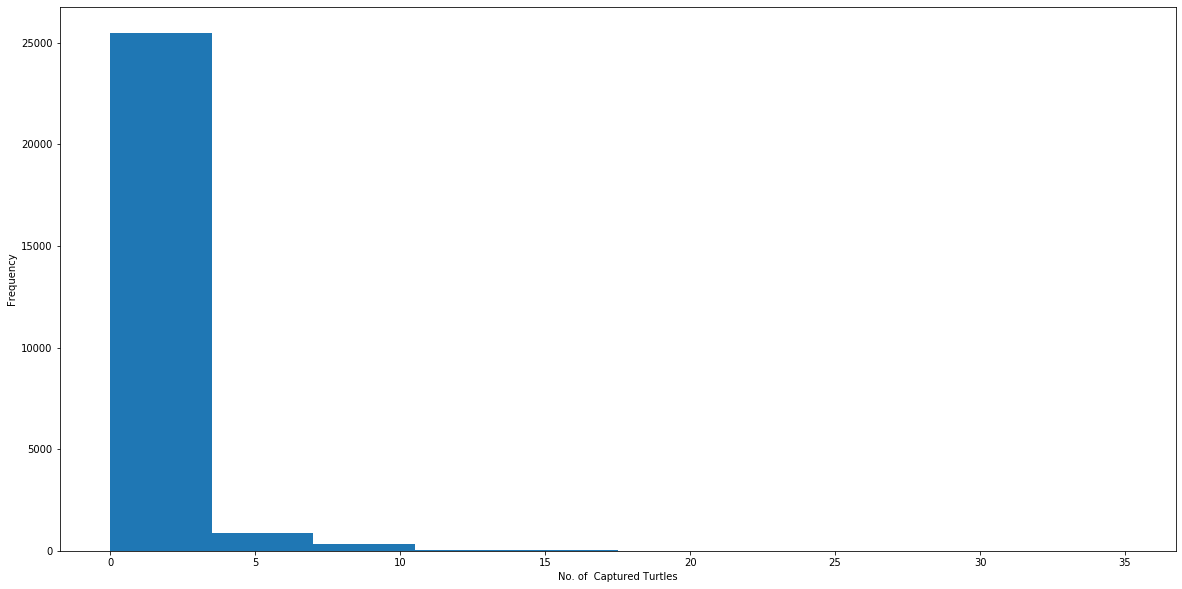

In [237]:
ax = df_dates['Capture_Number'].plot(kind='hist')
plt.xlabel('No. of  Captured Turtles')

In [238]:
df_dates.corr()["Capture_Number"].sort_values(ascending=False)

Capture_Number        1.000000
year_woy              0.190068
year                  0.188593
month                 0.051607
day_of_year           0.051572
week_of_year          0.048549
day_of_month         -0.000615
day_of_week_caught   -0.009141
Name: Capture_Number, dtype: float64

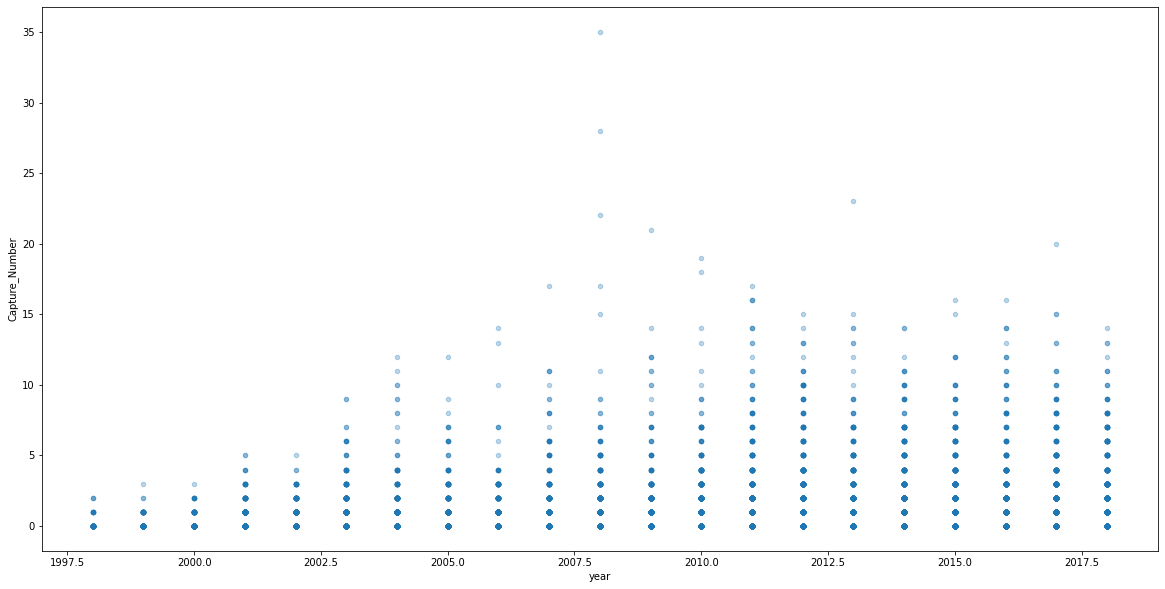

In [242]:
df_dates.plot(x='year', y='Capture_Number', kind='scatter', alpha=0.3)

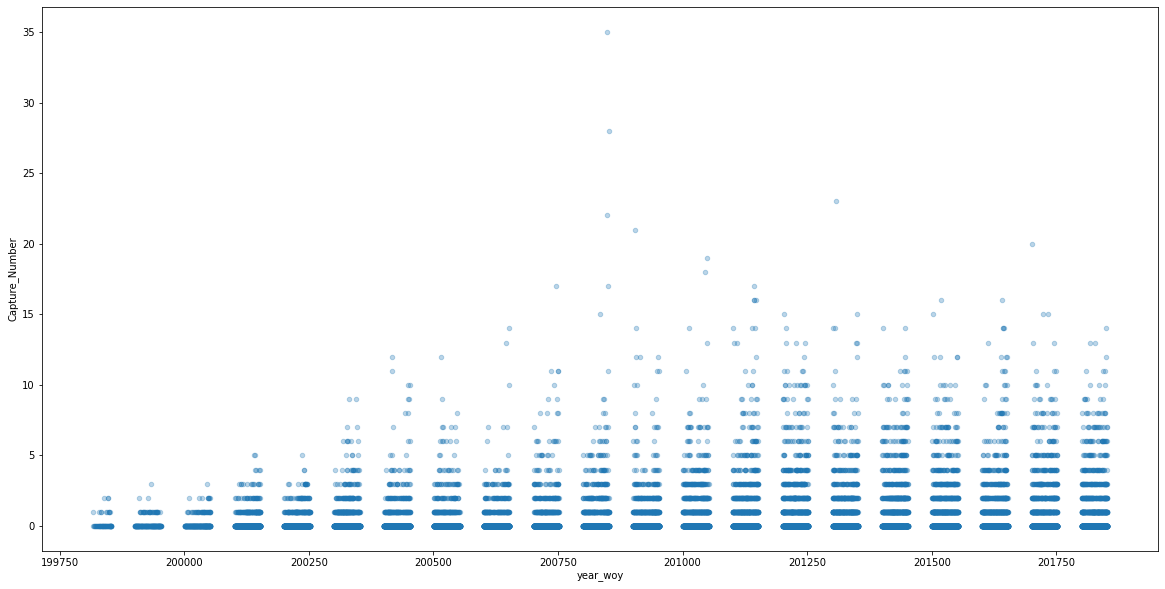

In [243]:
df_dates.plot(x='year_woy', y='Capture_Number', kind='scatter', alpha=0.3)

### Quick run through the modelling bit 

In [245]:
df_dates.tail()

,CaptureSite,CaptureSiteCategory,Type,Date_TimeCaught,year,week_of_year,year_woy,Capture_Number,day_of_year,month,day_of_week_caught,day_of_month,CaptureSite_id
28,CaptureSite_9,1,1,2018-11-26,2018,48,201848,6.0,330,11,0,26,9
28,CaptureSite_9,1,1,2018-12-03,2018,49,201849,6.0,337,12,0,3,9
28,CaptureSite_9,1,1,2018-12-10,2018,50,201850,12.0,344,12,0,10,9
28,CaptureSite_9,1,1,2018-12-17,2018,51,201851,5.0,351,12,0,17,9
28,CaptureSite_9,1,1,2018-12-24,2018,52,201852,3.0,358,12,0,24,9


In [247]:
remove_cols = df_dates.drop(['Capture_Number','Date_TimeCaught', 'CaptureSite'], axis=1).columns
remove_cols

Index(['CaptureSiteCategory', 'Type', 'year', 'week_of_year', 'year_woy',
       'day_of_year', 'month', 'day_of_week_caught', 'day_of_month',
       'CaptureSite_id'],
      dtype='object')

In [248]:
ycol = 'Capture_Number'

In [250]:
#Simple  regression model 
from sklearn.linear_model import LinearRegression
lm = LinearRegression()
lm.fit(df_dates[remove_cols], df_dates[ycol])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [251]:
from sklearn.metrics import mean_squared_error
from math import sqrt

print("RMSE:", sqrt(mean_squared_error(df_dates[ycol], lm.predict(df_dates[remove_cols]))))

RMSE: 1.5127492752484795


Text(0.5, 0, 'True Value')

Text(0, 0.5, 'Predicted Value')

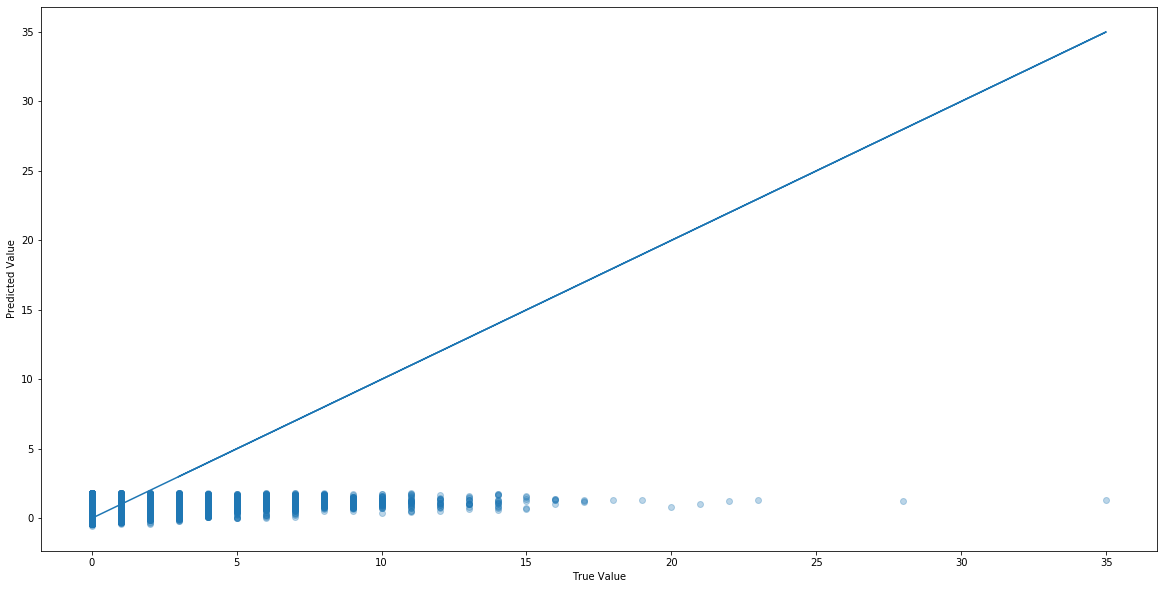

In [252]:
plt.scatter(df_dates[ycol], lm.predict(df_dates[remove_cols]), alpha=0.3)
plt.plot(df_dates[ycol], df_dates[ycol]) # A straight line - we want to be close to this
plt.xlabel('True Value')
plt.ylabel('Predicted Value')

The model didnt  perform well. True and  predicted values are wide apart. They should be  as close as possible.

## Random Forest

In [253]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=100) # Good model for  regression tasks
rf.fit(df_dates[remove_cols], df_dates[ycol])

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [254]:
print("RMSE:", sqrt(mean_squared_error(df_dates[ycol], rf.predict(df_dates[remove_cols]))))

RMSE: 0.46112704113415715


Text(0.5, 0, 'True Value')

Text(0, 0.5, 'Predicted Value')

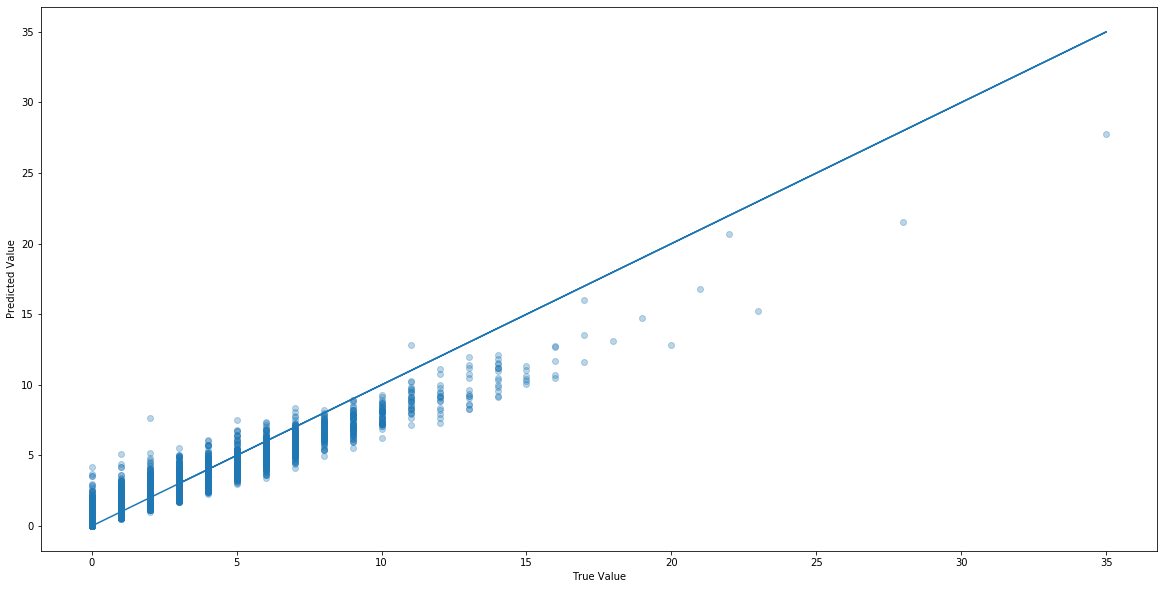

In [256]:
plt.scatter(df_dates[ycol], rf.predict(df_dates[remove_cols]), alpha=0.3)
plt.plot(df_dates[ycol], df_dates[ycol]) 
plt.xlabel('True Value')
plt.ylabel('Predicted Value')

Quite close to each other thus interesting results. Predicted values and  actual values are actually close 

### Feature importance

<Figure size 1800x720 with 0 Axes>

Text(0.5, 1.0, 'Feature Importances')

<BarContainer object of 10 artists>

([<matplotlib.axis.YTick at 0x2d0d651a908>,
 <a list of 10 Text yticklabel objects>)

Text(0.5, 0, 'Relative Importance')

Text(0.0016958989826478413, 0, ' 0.0016958989826478413')

Text(0.014224428209635891, 1, ' 0.014224428209635891')

Text(0.016718902460928248, 2, ' 0.016718902460928248')

Text(0.021242378104038787, 3, ' 0.021242378104038787')

Text(0.056825084505470295, 4, ' 0.056825084505470295')

Text(0.06036884355777236, 5, ' 0.06036884355777236')

Text(0.12015821712457235, 6, ' 0.12015821712457235')

Text(0.13184217268348367, 7, ' 0.13184217268348367')

Text(0.2875370734427058, 8, ' 0.2875370734427058')

Text(0.2893870009287448, 9, ' 0.2893870009287448')

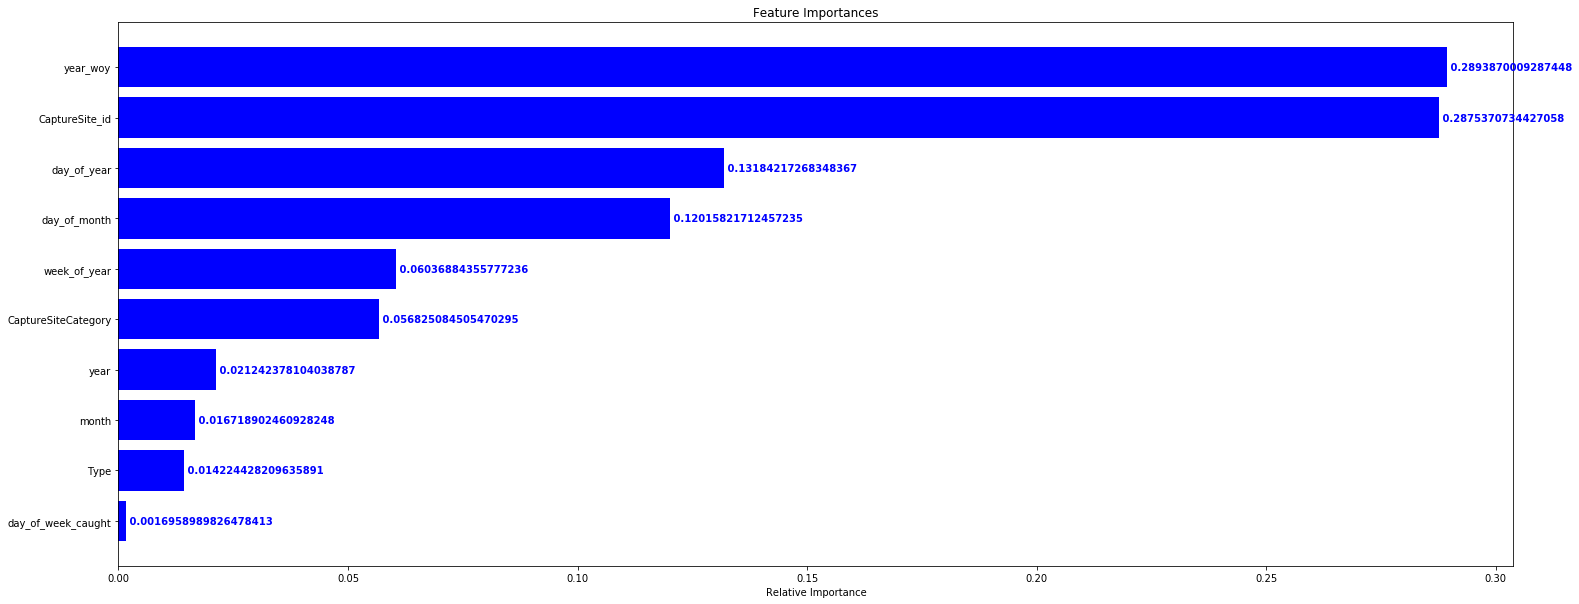

In [258]:
features = remove_cols
importances = rf.feature_importances_
indices = np.argsort(importances)
# fig, ax = plt.subplots()    
plt.figure(figsize=(25,10))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
for i, v in enumerate(importances[indices]):
    plt.text(v, i, " "+str(v), color='blue', va='center', fontweight='bold')
plt.show()

### Avoiding  Overfitting  

In [259]:
##Using Kfolds validation 

from sklearn.model_selection import KFold

# Demonstrating splits
kf = KFold(n_splits=10, shuffle=False)
for train, test in kf.split(df_dates):
  print(df_dates.iloc[train].shape, df_dates.iloc[test].shape)

(24094, 13) (2678, 13)
(24094, 13) (2678, 13)
(24095, 13) (2677, 13)
(24095, 13) (2677, 13)
(24095, 13) (2677, 13)
(24095, 13) (2677, 13)
(24095, 13) (2677, 13)
(24095, 13) (2677, 13)
(24095, 13) (2677, 13)
(24095, 13) (2677, 13)


In [260]:
kf = KFold(n_splits=10, shuffle=True)

scores = []
for train, test in kf.split(df_dates):
  rf = RandomForestRegressor(n_estimators=100)
  rf.fit(df_dates[remove_cols].iloc[train], df_dates[ycol].iloc[train])
  rmse = sqrt(mean_squared_error(df_dates[ycol].iloc[test], rf.predict(df_dates[remove_cols].iloc[test])))
  scores.append(rmse)
  print(rmse)

print("Average score in 10-fold CV:", np.mean(scores))

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

1.2372834260288208


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

1.161725446028112


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

1.2058778966715435


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

1.2254776233389353


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

1.2033137225304271


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

1.1445834335943896


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

1.239042386929577


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

1.2764530931711195


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

1.242449455704868


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

1.3452826585714688
Average score in 10-fold CV: 1.2281489142569262


In [261]:
### Some more fine tuning  
for md in [5, 6, 8, 9, 10]:
    scores = []
    for train, test in kf.split(df_dates):
        rf = RandomForestRegressor(n_estimators=100, max_depth=md)
        rf.fit(df_dates[remove_cols].iloc[train], df_dates[ycol].iloc[train])
        rmse = sqrt(mean_squared_error(df_dates[ycol].iloc[test], rf.predict(df_dates[remove_cols].iloc[test])))
        scores.append(rmse)
    print("Average score in 10-fold CV:", np.mean(scores), "for max depth:", md)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=5,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=5,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=5,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=5,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=5,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=5,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=5,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=5,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=5,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=5,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

Average score in 10-fold CV: 1.3236876653186502 for max depth: 5


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=6,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=6,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=6,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=6,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=6,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=6,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=6,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=6,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=6,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=6,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

Average score in 10-fold CV: 1.2571083054461747 for max depth: 6


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=8,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=8,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=8,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=8,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=8,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=8,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=8,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=8,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=8,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=8,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

Average score in 10-fold CV: 1.2082578452522204 for max depth: 8


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=9,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=9,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=9,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=9,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=9,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=9,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=9,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=9,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=9,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=9,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

Average score in 10-fold CV: 1.193162110162519 for max depth: 9


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

Average score in 10-fold CV: 1.1897261428182493 for max depth: 10


In [262]:
rf = RandomForestRegressor(n_estimators=100, max_depth=9)
rf.fit(df_dates[remove_cols], df_dates[ycol])

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=9,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [263]:
df_submission['Capture_Number'] = rf.predict(df_submission[remove_cols])

In [264]:
df_submission['ID'] = df_submission["CaptureSite"]+ "_" + df_submission["year_woy"].map(str)

In [268]:
df_submission['Capture_Number'] = df_submission['Capture_Number'].apply(np.round).astype(int) ## Capture numbers are e rounded here. THere is nothing like 0.7 turtles

In [272]:
df_submission.head()

,CaptureSite,CaptureSiteCategory,Type,Date_TimeCaught,year,week_of_year,year_woy,Capture_Number,day_of_year,month,day_of_week_caught,day_of_month,CaptureSite_id,ID
0,CaptureSite_0,2,1,2019-01-01,2019,1,201901,1,1,1,1,1,0,CaptureSite_0_201901
0,CaptureSite_0,2,1,2019-01-07,2019,2,201902,1,7,1,0,7,0,CaptureSite_0_201902
0,CaptureSite_0,2,1,2019-01-14,2019,3,201903,1,14,1,0,14,0,CaptureSite_0_201903
0,CaptureSite_0,2,1,2019-01-21,2019,4,201904,1,21,1,0,21,0,CaptureSite_0_201904
0,CaptureSite_0,2,1,2019-01-28,2019,5,201905,1,28,1,0,28,0,CaptureSite_0_201905


In [271]:
df_submission[['ID', 'Capture_Number']].to_csv('submission.csv', index=False)

In [270]:
df_submission[['ID', 'Capture_Number']]

,ID,Capture_Number
0,CaptureSite_0_201901,1
0,CaptureSite_0_201902,1
0,CaptureSite_0_201903,1
0,CaptureSite_0_201904,1
0,CaptureSite_0_201905,1
0,CaptureSite_0_201906,1
0,CaptureSite_0_201907,1
0,CaptureSite_0_201908,1
0,CaptureSite_0_201909,1
0,CaptureSite_0_201910,1
